In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()

In [2]:
df= pd.read_pickle("final_train_test_risk_score.pkl.bz2",compression="bz2")

In [3]:
df.head(2).T

,0,1
defaul_payment_hist,0,0
credit_history,10957,5114
open_acc,3,3
indebtedness,0,0
member_id,786442,655371
amount,180957,151353
mf_return,1.90006e+07,6.16484e+06
balance,260478,221916
score,267.434,168.518
improvement,investment_score,investment_score


In [4]:
df.drop(["improvement","member_id"],axis=1,inplace=True)

In [5]:
X=df.drop(columns="score",axis=1)
y=df["score"]

In [6]:
X.columns

Index(['defaul_payment_hist', 'credit_history', 'open_acc', 'indebtedness',
       'amount', 'mf_return', 'balance', 'cumulative_tenure',
       'cumulative_inv_amount', 'cumulative_risk', 'total_mfs', 'total_tenure',
       'mf_cat_equity_scheme', 'mf_cat_debt_scheme', 'mf_cat_other_scheme',
       'mf_cat_hybrid_scheme', 'mf_cat_solution_scheme', 'mf_cat_others'],
      dtype='object')

In [10]:
# Test ,Train split
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7,test_size=0.3,random_state=100)

In [8]:
X_train = scaler.fit_transform(X_train)

In [9]:
X_test = scaler.fit_transform(X_test)

In [11]:
y_train.shape

(26385,)

In [12]:
X_train.shape

(26385, 18)

In [13]:
from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation ,Flatten
from tensorflow.keras.callbacks import ModelCheckpoint

In [40]:
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='softmax'))

# Compile the network :
NN_model.add(Dense(1, activation='sigmoid'))
# Compile model
NN_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
NN_model.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 128)               2432      
_________________________________________________________________
dense_21 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_22 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_23 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 257       
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 2         
Total params: 167,299
Trai

In [41]:
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [ ]:
NN_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

In [43]:
NN_model.load_weights("Weights-050---15185.31632.hdf5") # load it
NN_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [44]:
result=NN_model.predict(X_test)

In [45]:
result

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

In [87]:
def flatten(t):
    return [item for sublist in t for item in sublist]

In [74]:
y_pred=NN_model.predict_on_batch(X_test)
y_pred.shape

(11308, 1)

In [73]:
y_test_arr=np.array(y_test)
y_test_arr=y_test_arr.reshape(y_test_arr.shape[0],-1)
y_test_arr.shape

(11308, 1)

In [52]:
diff=y_pred-np.array(y_test)

In [53]:
diff.shape

(11308,)

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

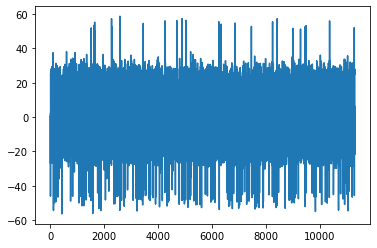

In [66]:
plt.plot(diff)

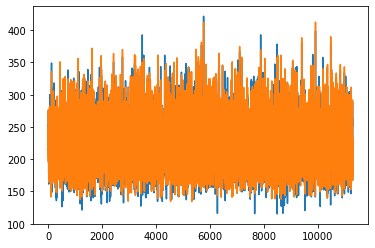

In [67]:
plt.plot(y_test_arr)
plt.plot(y_pred)

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(generated_target, out, squared=False)

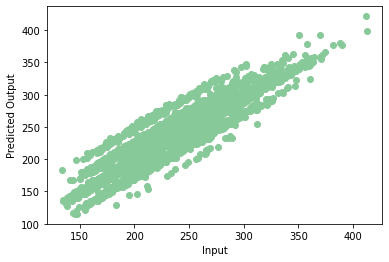

In [76]:
plt.scatter(np.squeeze(NN_model.predict_on_batch(X_test)),np.squeeze(y_test_arr),c='#88c999')
plt.xlabel('Input')
plt.ylabel('Predicted Output')
plt.show()

In [81]:
NN_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               2432      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 167,297
Trainable params: 167,297
Non-trainable params: 0
_________________________________________________________________


In [82]:
# serialize model to JSON
model_json = NN_model.to_json()

with open("model_user_score.json", "w") as json_file:
    json_file.write(model_json)